In [1]:
# --------------------------------------------------------------------------------
# "THE BEER-WARE LICENSE" (Revision 42):
# Philipp Jaeger <p@pj4e.de> wrote this file. As long as you retain this notice 
# you can do whatever you want with this stuff. If we meet some day, and you think
# this stuff is worth it, you can buy me a beer or a coffee in return.      
#                                                             Philipp Jaeger
# --------------------------------------------------------------------------------


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.optimize as opt
import scipy

from typing import List, Any
from dataclasses import InitVar, dataclass, astuple, is_dataclass

%matplotlib inline
plt.rcParams['figure.figsize'] = [12,8]
plt.rcParams['figure.dpi'] = 200


In [2]:
country = "Canada"
csse_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
df = pd.read_csv(csse_url)
df = df.rename(columns={df.columns[0]: "Province", df.columns[1]: "Country"})
df = df[df["Country"] == country]
del df["Country"] 
del df["Lat"] 
del df["Long"]

df = df.transpose()
df.columns = df.loc["Province"] if len(df.loc["Province"]) > 1 else [country]
df = df.drop(index="Province")

which = ["British Columbia", "Alberta", "Saskatchewan", "Manitoba"]
#which = df.columns

In [3]:
dfn = df.copy()
for i in dfn:
    dfn[i] = dfn[i]/max(dfn[i])

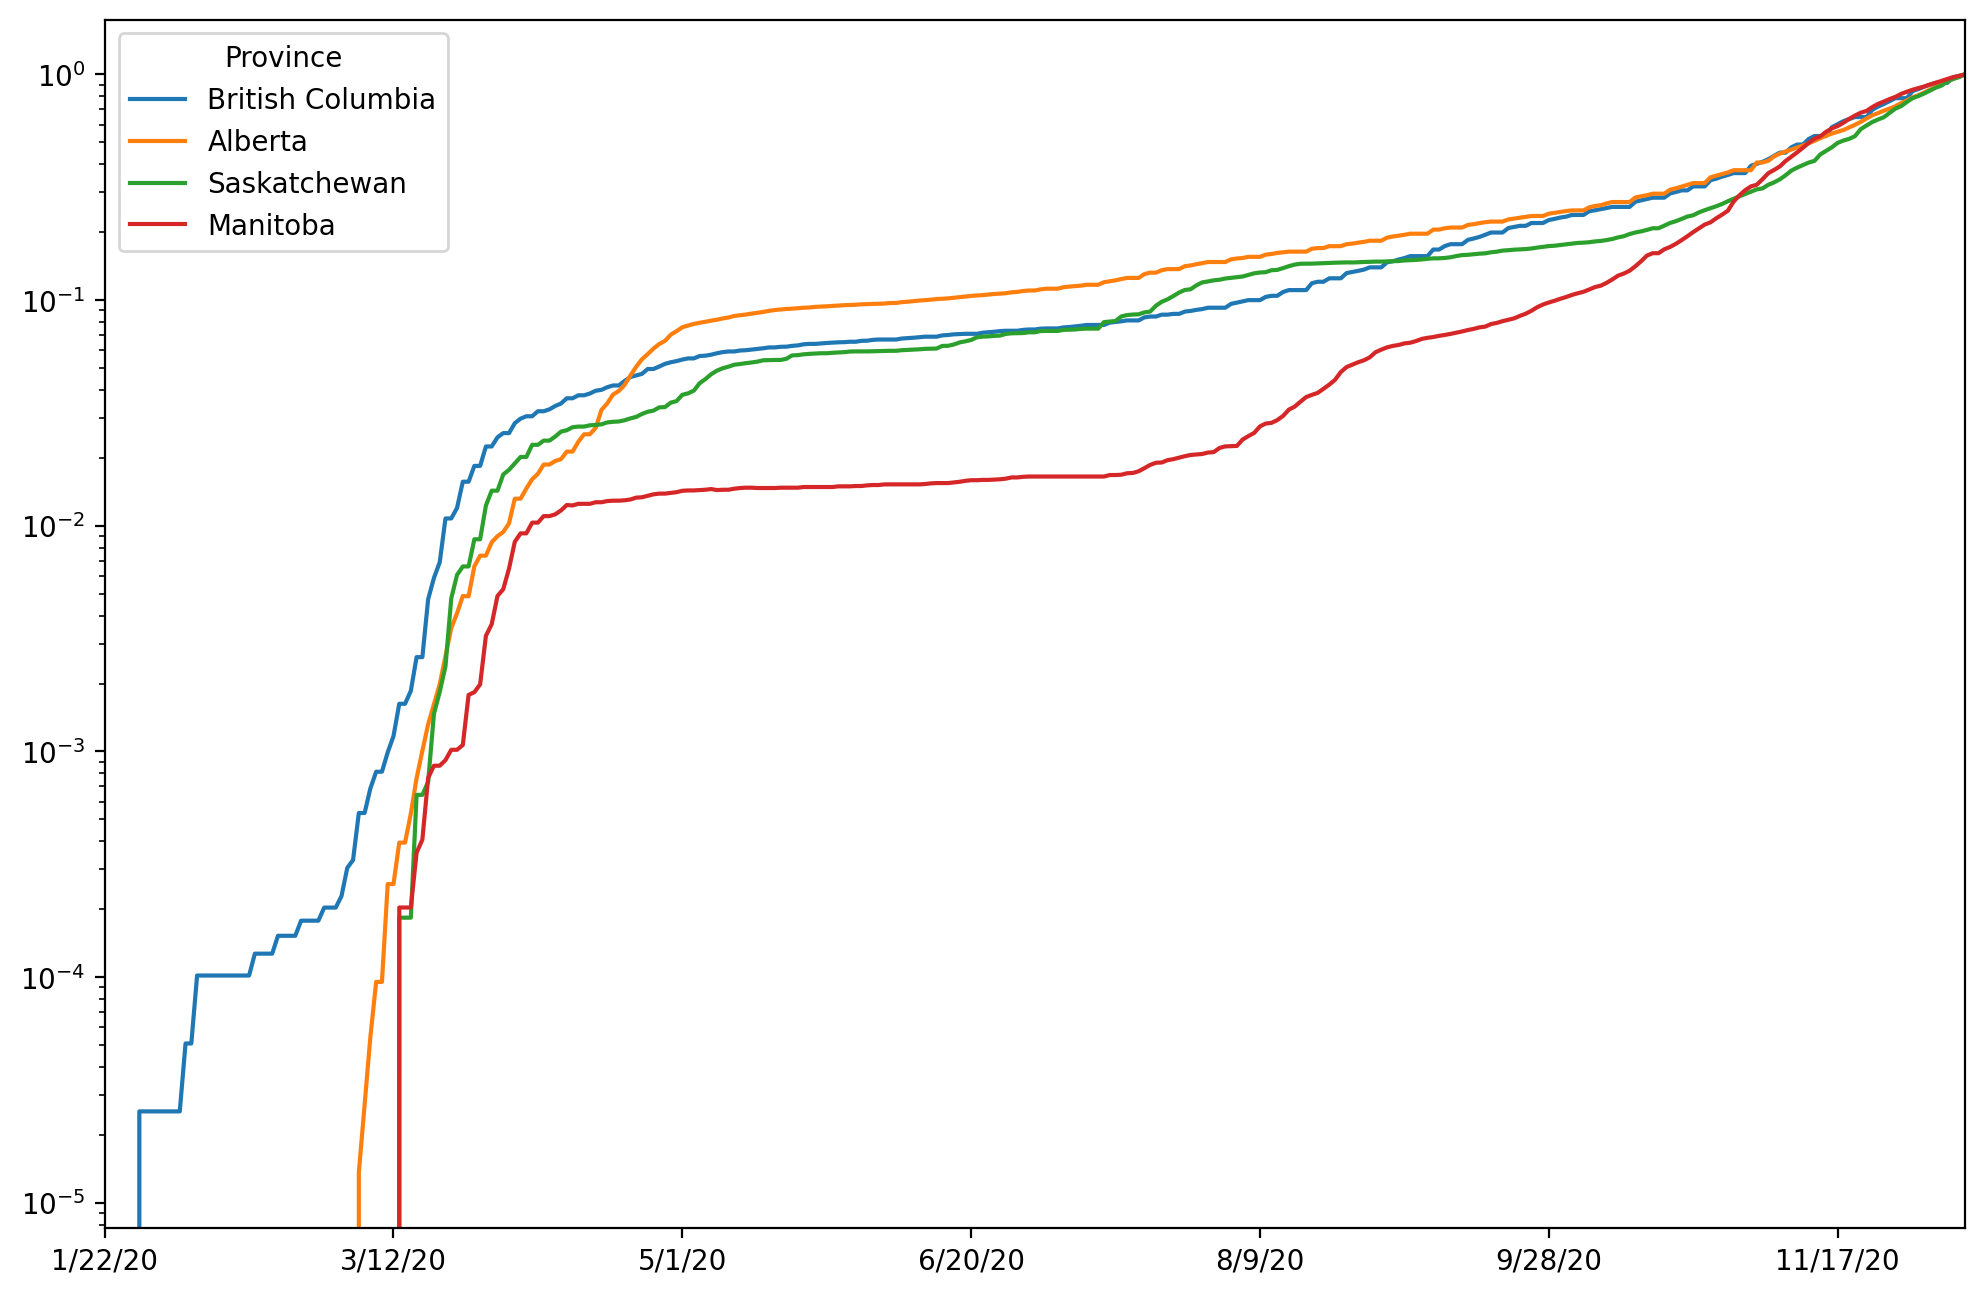

In [4]:
dfn.plot(y=which, logy=True)

In [46]:
avg_days = 7
diff = (df.diff().rolling(avg_days).mean()).dropna()
diff.to_csv("diff.csv")

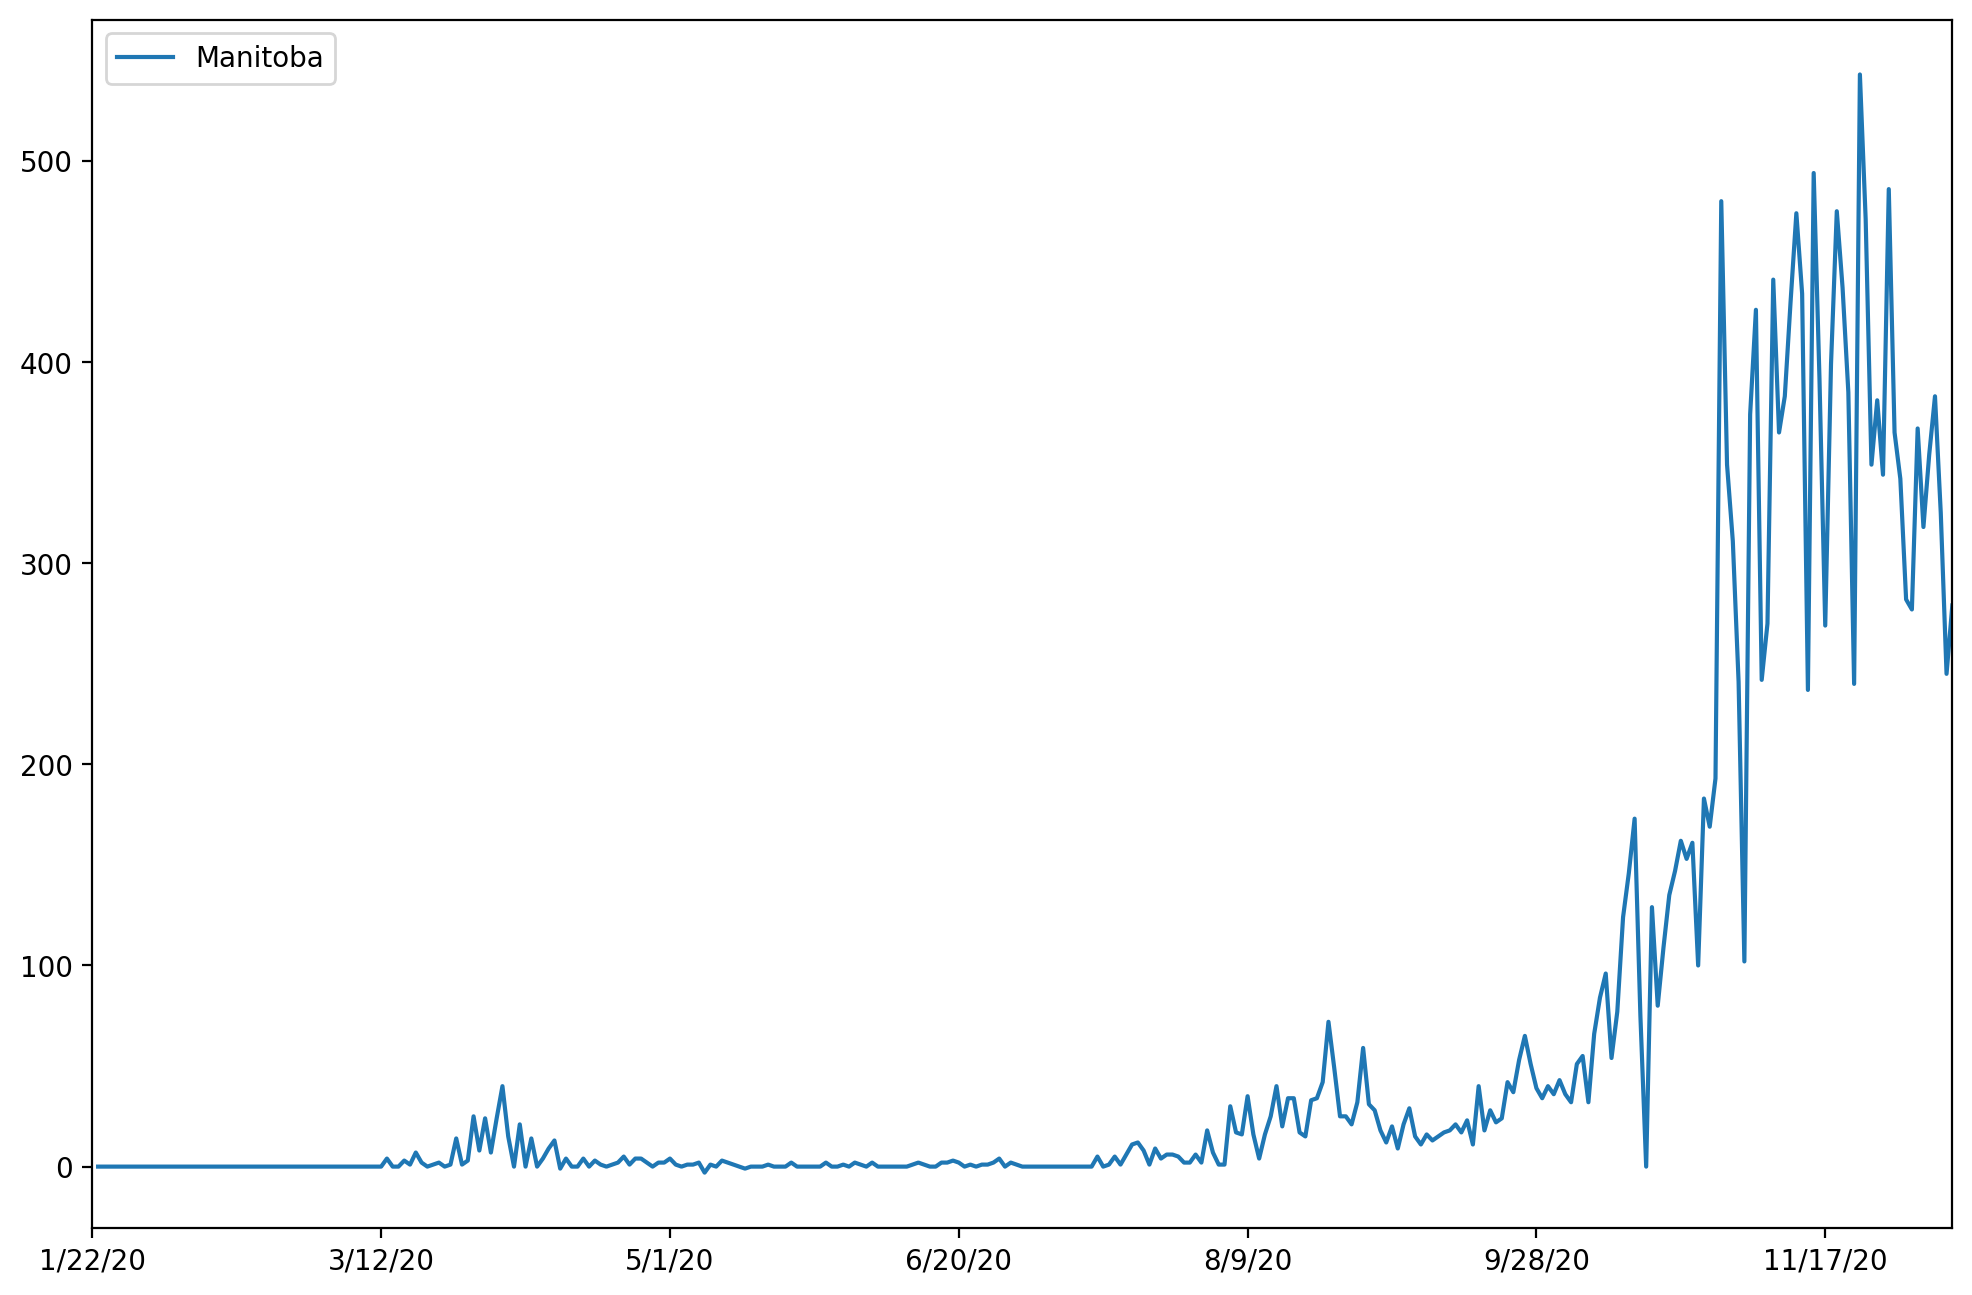

In [47]:
df.diff().plot(y="Manitoba", logy=False)

In [48]:
diffn = diff.copy()
for i in diffn:
    diffn[i] = diffn[i]/max(diffn[i])
diffn = diffn.where(diffn > 0, 0)
#diffn.plot(y=which)

In [49]:
from dataclasses import InitVar, dataclass, field, astuple, asdict, is_dataclass

@dataclass
class DataclassIter:
    dc: Any
    t: InitVar[type]
    index: int = 0
    formater: Any = field(init=False)
    def __post_init__(self, t):
        if t == tuple or t == list:
            self.formater = lambda obj: list(astuple(obj))
        elif t == dict:
            self.formater = lambda obj: list(asdict(obj).items())
        else:
            raise TypeError("Allowed values for t are `dict`, `tuple`, or `list`")
    def __next__(self):
        if self.index < len(self.formater(self.dc)):
            ret = self.formater(self.dc)[self.index]
            self.index += 1
            return ret
        raise StopIteration
        
def iterable(t=dict):
    def wrap(dc):
        if is_dataclass(dc):
            if not hasattr(dc, "__iter__"):
                setattr(dc, "__iter__", lambda self: DataclassIter(self, t))
            return dc
        else:
            raise TypeError("This function only works for dataclasses.")
    return wrap
    
def unpack(func):
    def call(x, *params):
        params_list = []
        for param in params:
            try:
                for p in param:
                    params_list.append(p)
            except TypeError:
                params_list.append(param)
        return func(x, *params_list)
    return call
                

In [50]:
@iterable(list)
@dataclass
class LorenzOpt:
    amp: float = 10
    cen: float = 100
    wid: float = 10    

def _lorenz(x, amp, cen, wid):
    return amp*wid**2/((x-cen)**2+wid**2)

@unpack
def model(x, *params):
    ret = 0
    for l in range(len(params)//3):
        ret += _lorenz(x, params[3*l], params[3*l+1], params[3*l+2])
    return ret



In [51]:
l = LorenzOpt(cen=5)
model(1, 1, 100, 5, l)

8.623233925475692

In [52]:
y = np.asarray(diff.Manitoba)
x = np.arange(len(y))

centres = [70, 180, 200, 250, 270, 280, 290, 300]
ampl = [10, 30, 30, 50, 100, 100, 300, 500]

par = [astuple(LorenzOpt(cen=centres[i//3]))[i%3] for i in range(3*len(centres))]

popt_all = []
for i in range(1):
    y = np.asarray(diff.Manitoba) if i == 0 else np.asarray(diff.Manitoba)[:-7*i]
    x = np.arange(len(y))
    popt, pcov = scipy.optimize.curve_fit(
        model,
        x,
        y,
        p0=par,
        maxfev=10000,
        bounds=(0, np.inf)
    )
    popt_all.append(popt.copy())

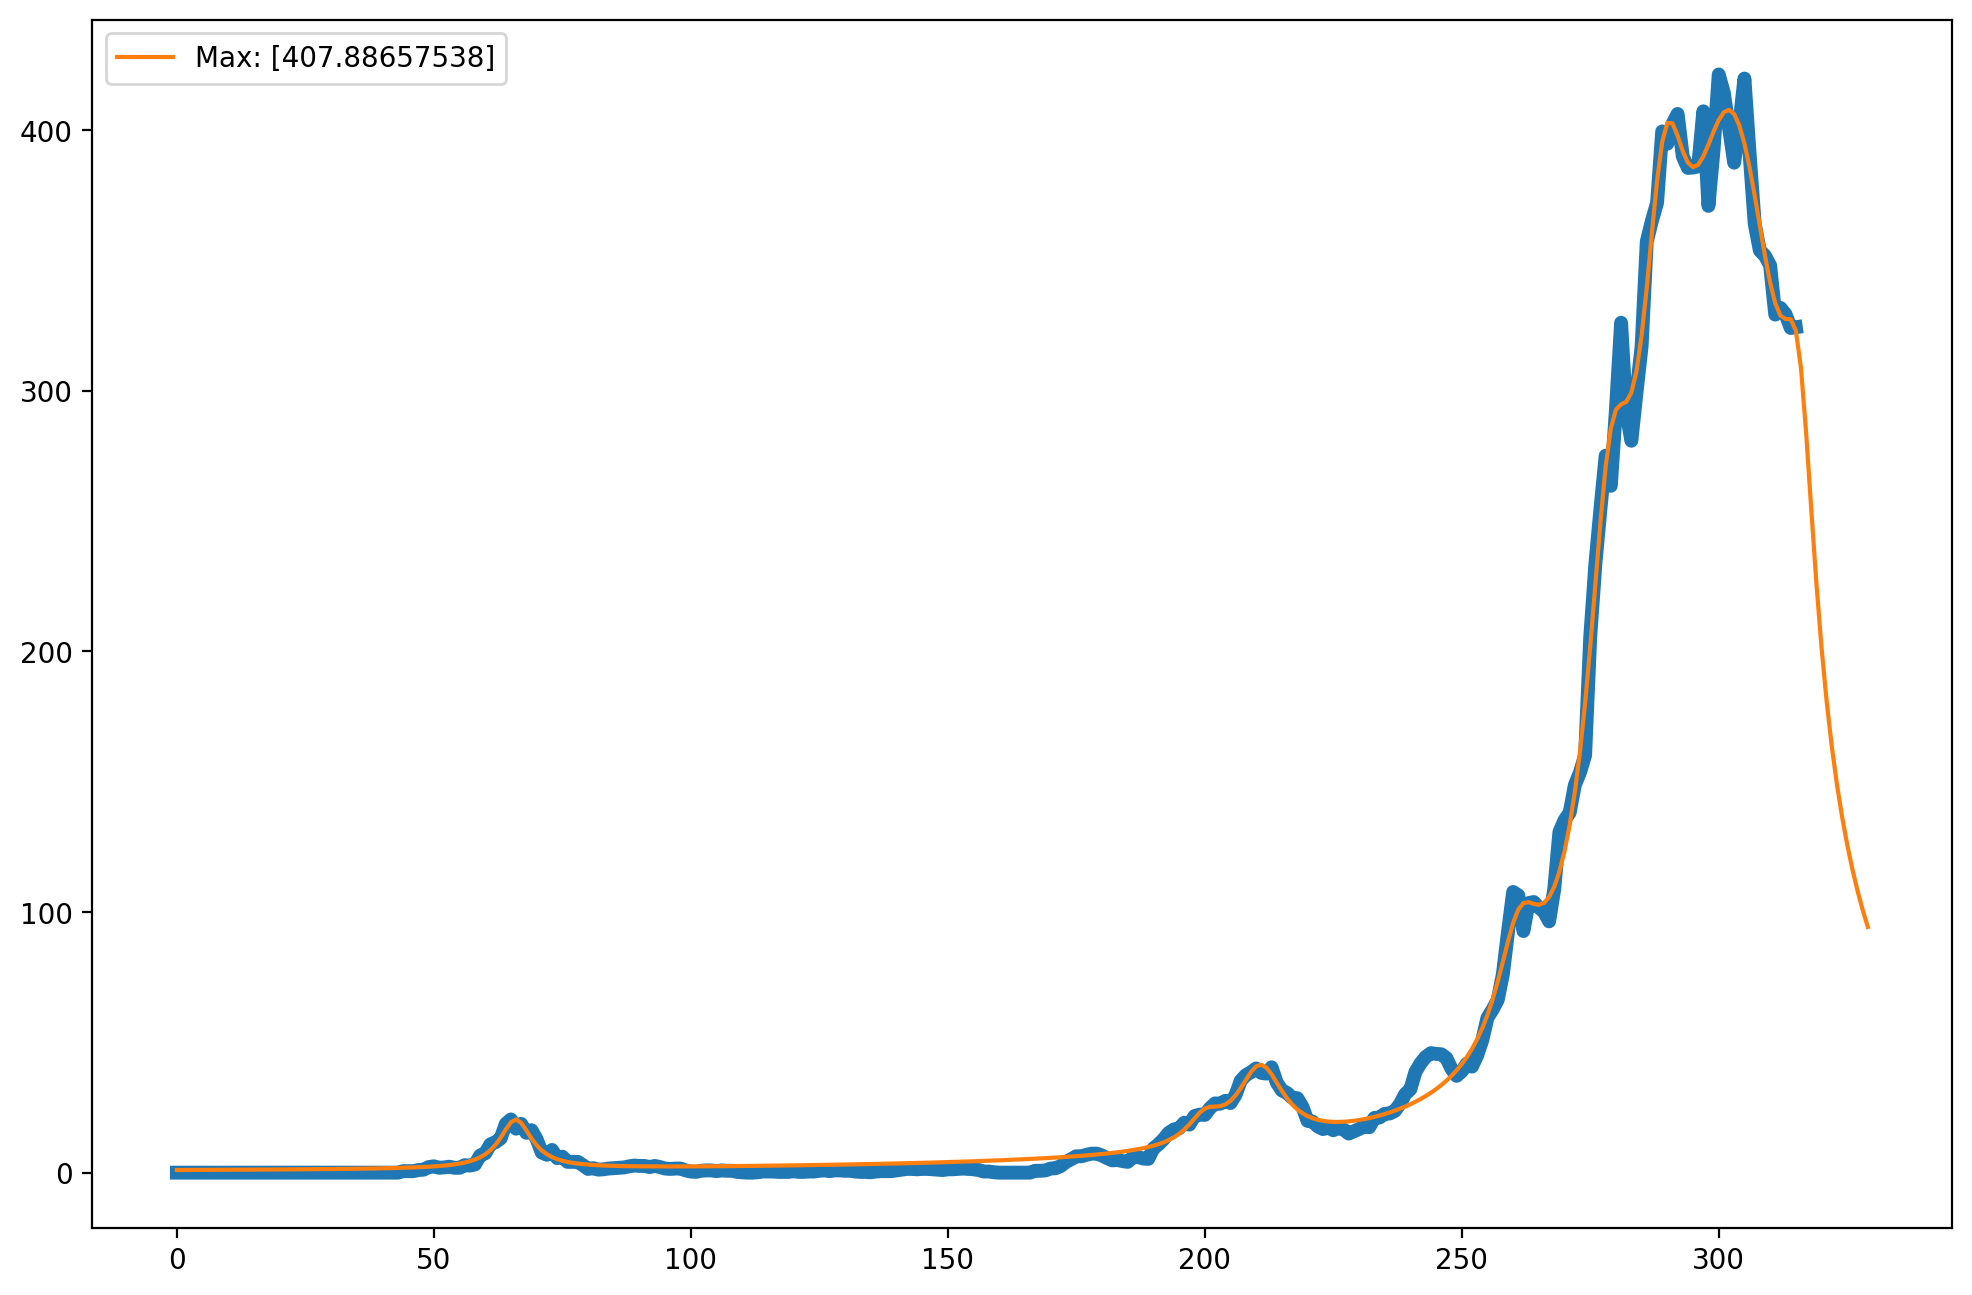

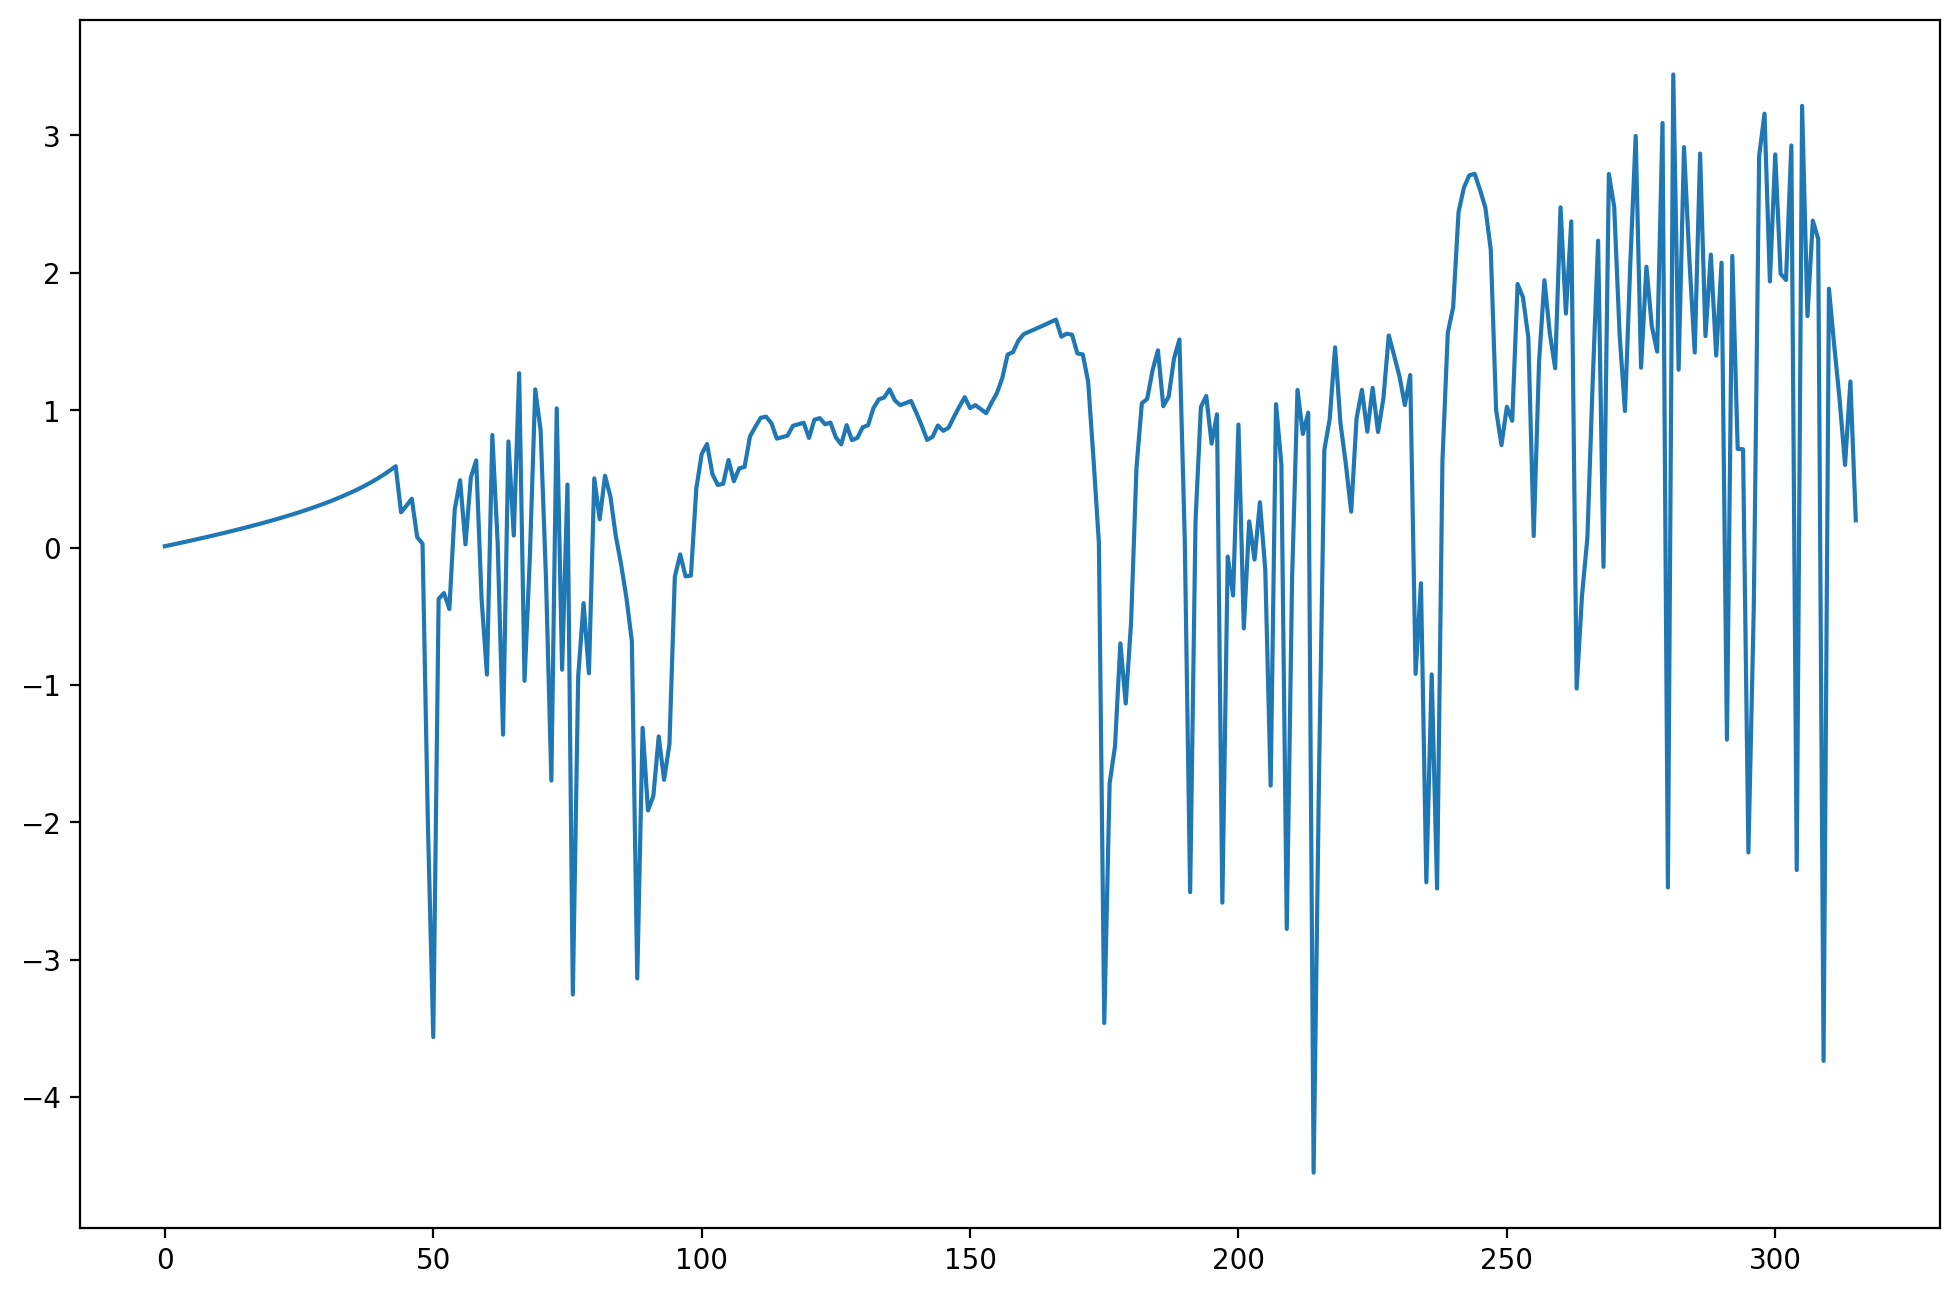

In [53]:
y = np.asarray(diff.Manitoba)
x = np.arange(len(y))
xn = np.arange(330)
plt.figure()
plt.plot(x, y, linewidth=5)
for popt in popt_all:
    def _func(x):
        return -model(x, *popt)
    maxi = scipy.optimize.fmin(lambda xi: _func(xi), len(y), disp=False)
    plt.plot(xn, model(xn, *popt), label="Max: {}".format(model(maxi, *popt)))
plt.legend()

plt.figure()
popt = popt_all[0]
plt.plot(x, np.log(np.abs(y-model(x, *popt))))

In [13]:
[popt[3*i+1] for i in range(len(centres))]
popt

array([ 18.85196531,  65.93956144,   3.83361792,   9.99381533,
       200.05346939,   4.12718771,  29.55933787, 210.82694408,
         5.57833841,  44.26611898, 261.16515106,   5.37382901,
       179.22025174, 289.34339856,   5.9422982 , 145.47085279,
       278.8913004 ,   5.53342825, 108.06013188, 315.5471471 ,
         4.08690085, 359.2419069 , 302.90711244,  13.86651811])

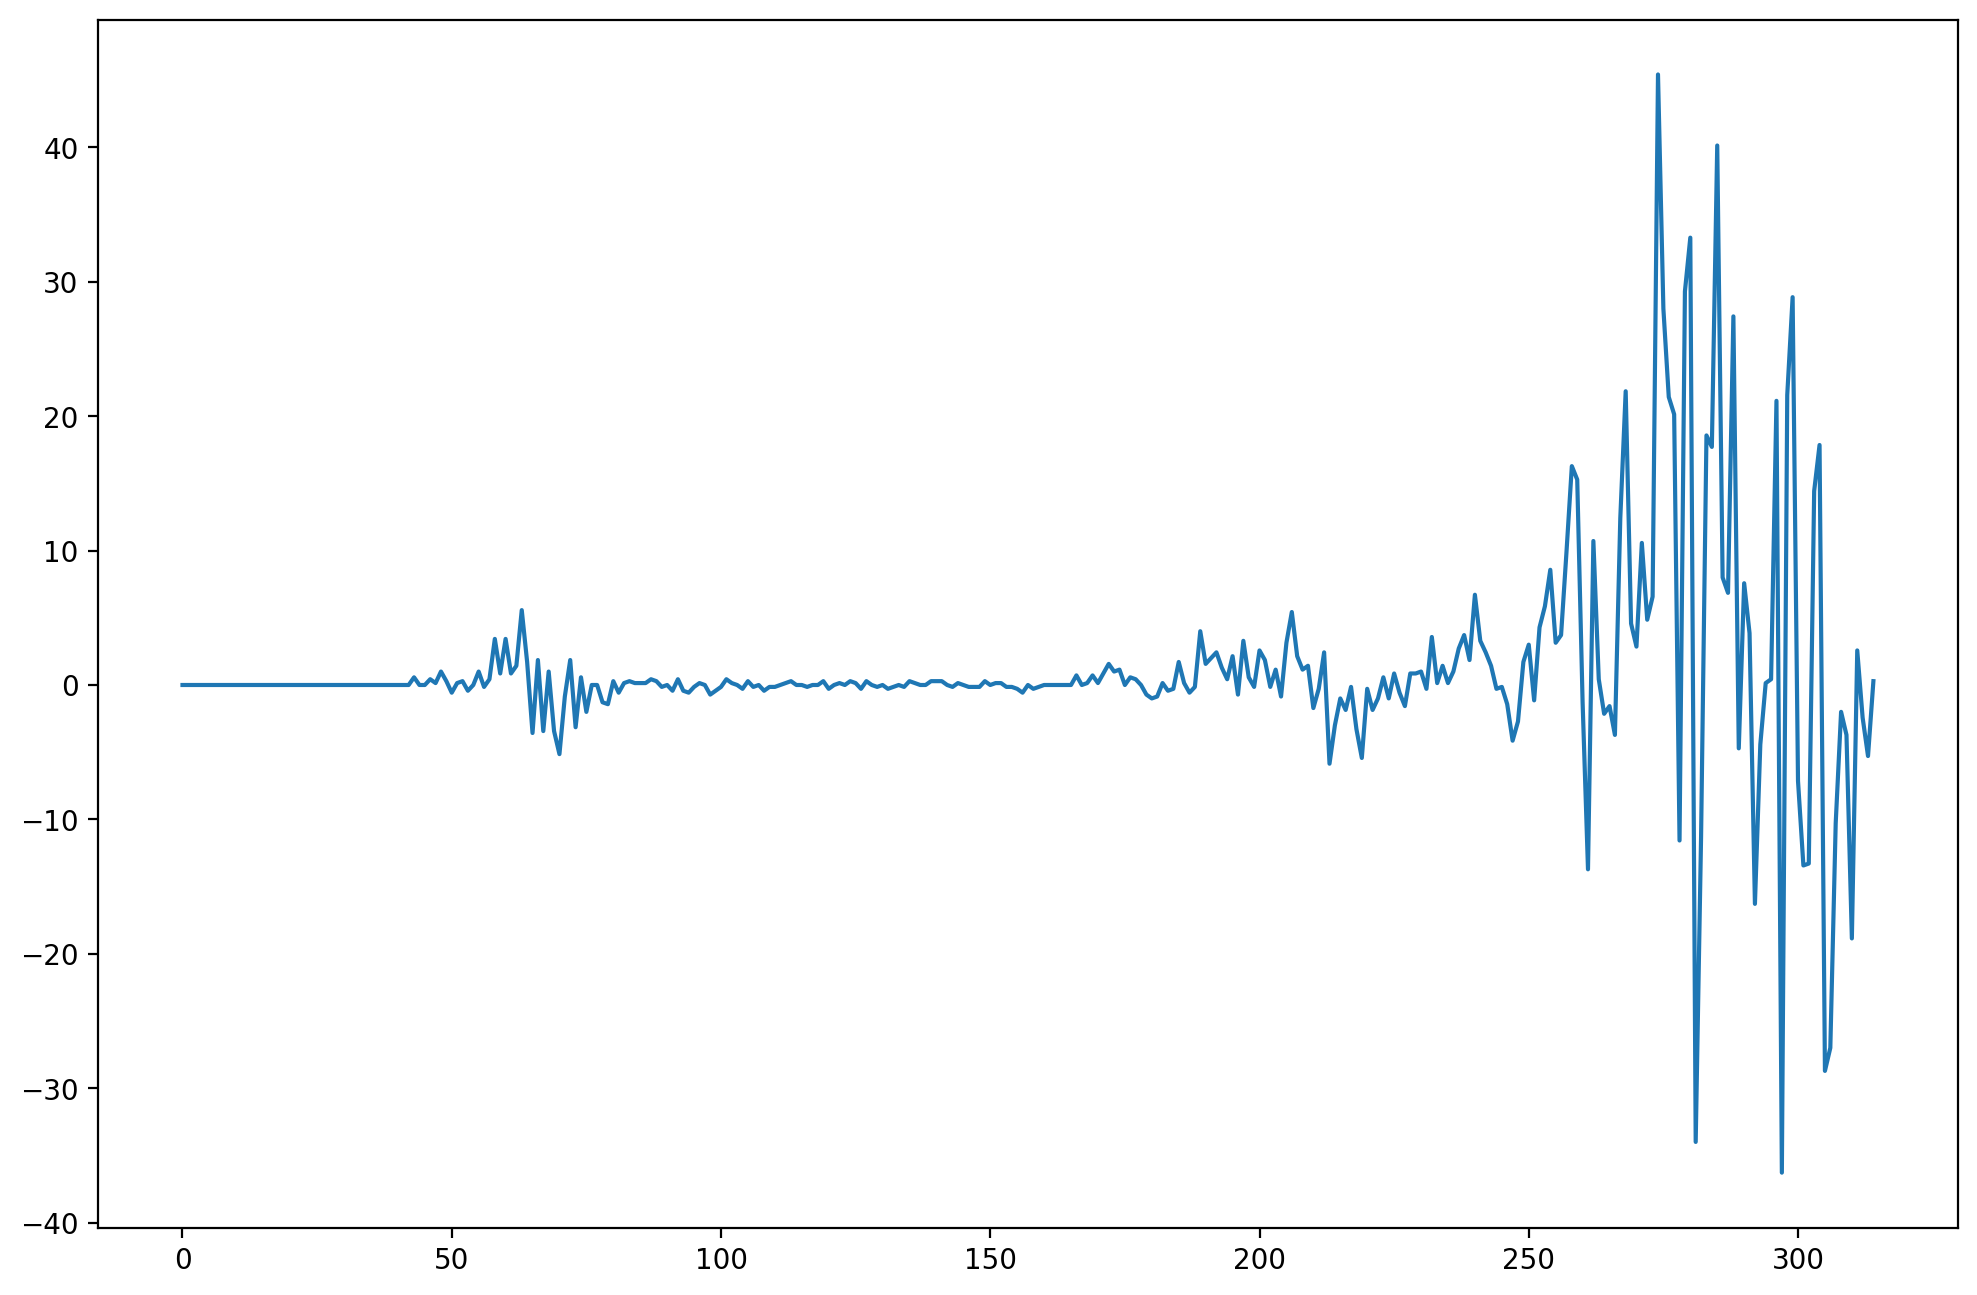

In [14]:
yd=y[1:]-y[:-1]
plt.plot(np.arange(len(yd)), yd)

/usr/lib64/python3.8/site-packages/pandas/core/frame.py:6992: RuntimeWarning: divide by zero encountered in log
  return lib.map_infer(x.astype(object).values, func)


<Figure size 2400x1600 with 0 Axes>

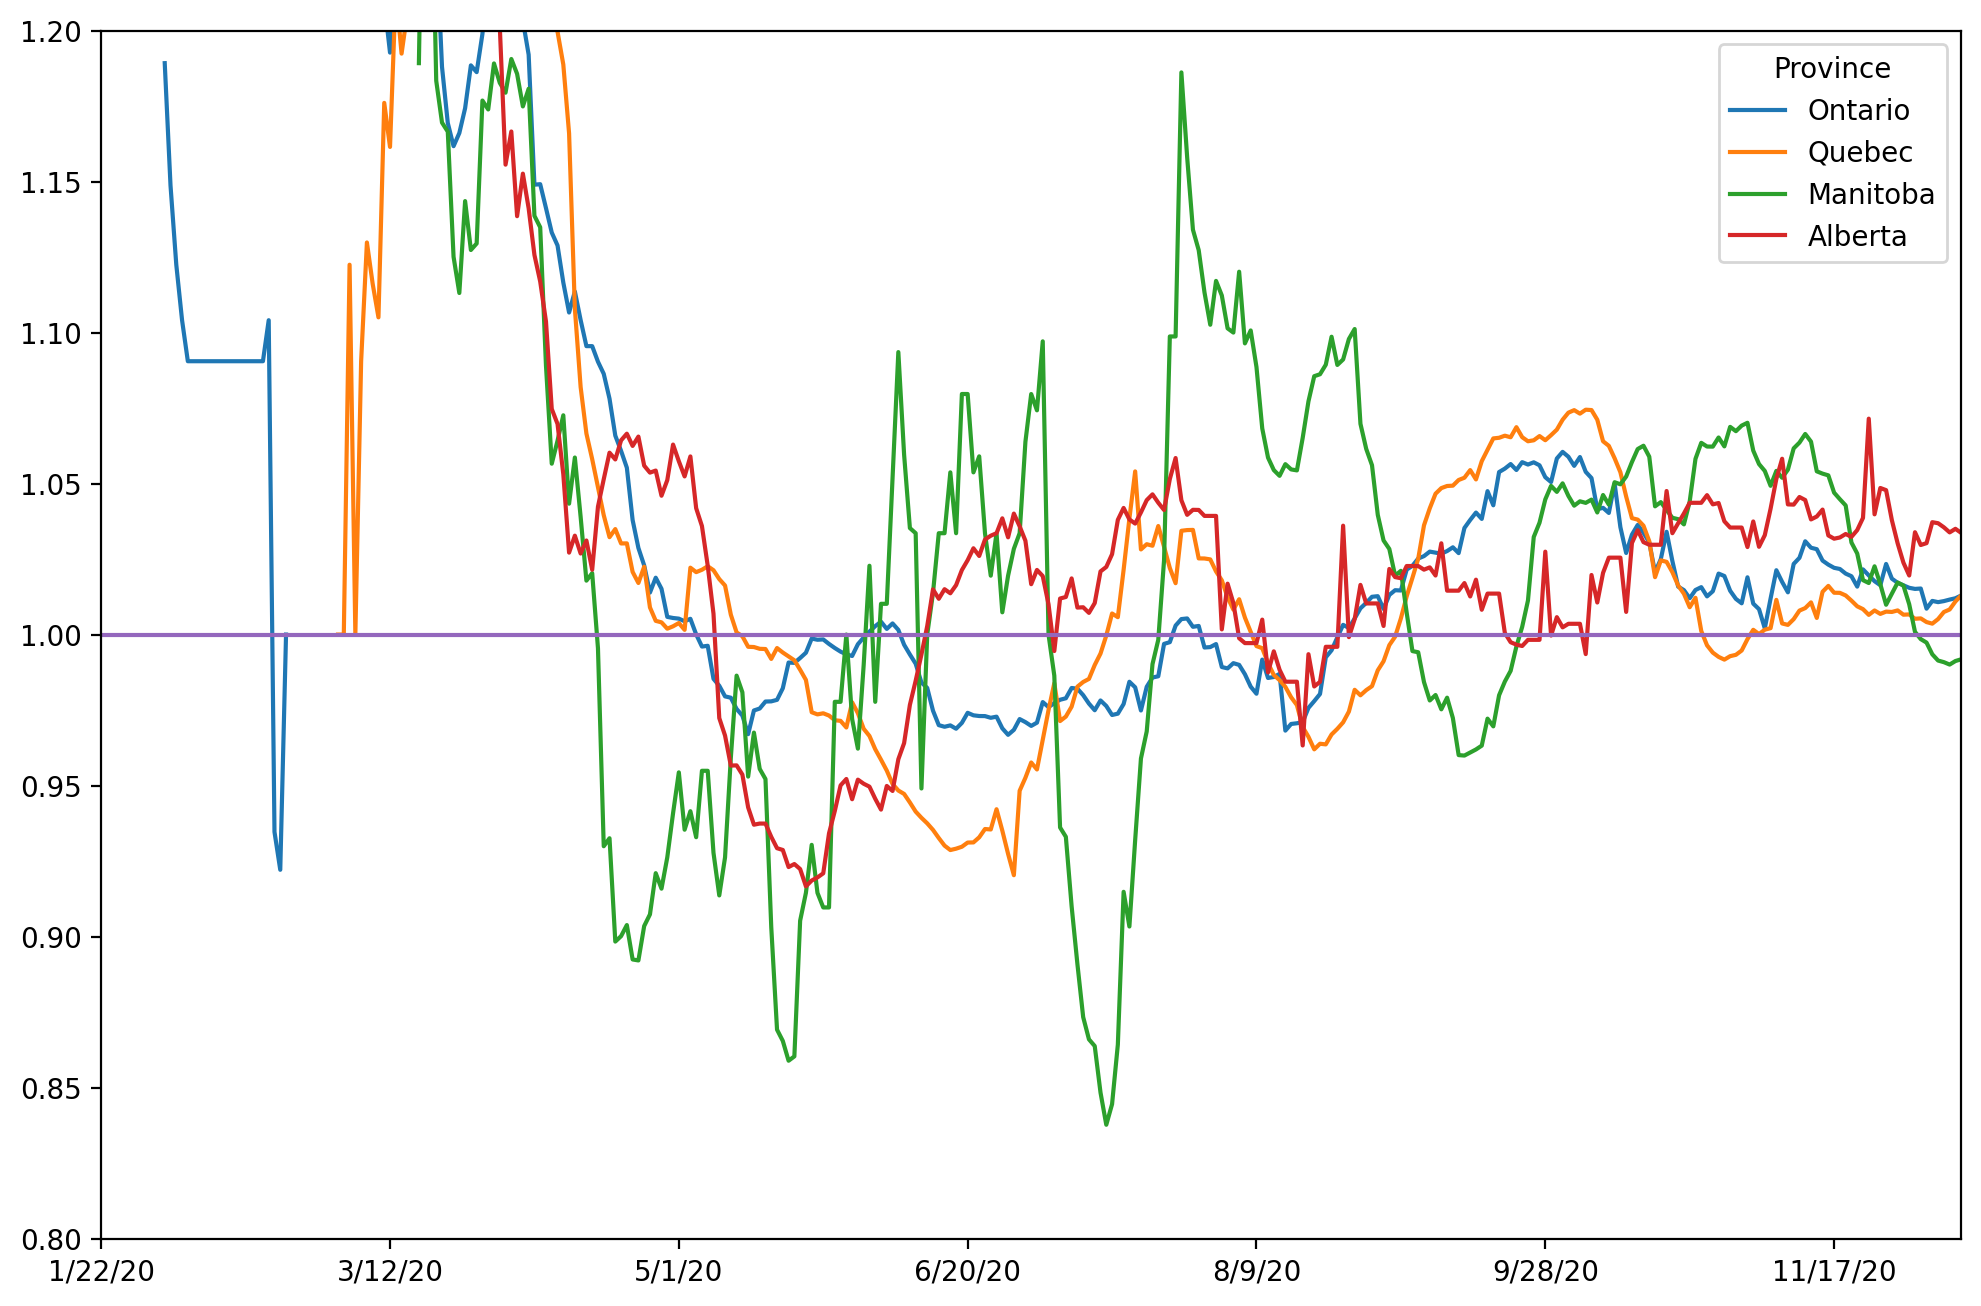

In [36]:
avg_days = 7
smooth_avg_days = 21
which = ["Ontario", "Quebec", "Manitoba", "Alberta"]
r = df[which].rolling(avg_days).mean()\
    .diff().applymap(np.log).diff()\
    .rolling(smooth_avg_days, min_periods=4).mean().apply(np.exp)
plt.figure()
r.plot(ylim=[0.8, 1.2])
plt.plot(df.index, [1 for x in df.index])

In [16]:
np

<module 'numpy' from '/usr/lib64/python3.8/site-packages/numpy/__init__.py'>